# FWI on field data (CGG Broadseis)

by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [16]:
import os
import sys
#api._cmd('conda activate torch2')
print(f'Python: {sys.prefix}')
import copy
from glob import glob
# import glob
import numpy as np
import importlib
import multiprocessing
import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
from utils import shared as sd
from utils import loaders as ld
from utils import vis
from IPython.display import clear_output
# append path with actual source files to sys.path
sys.path.append(os.path.abspath('../codes_server'))
sys.path.append(os.path.abspath('./utils'))
from F_utils import *
from F_fwi import *
import pyapi_denise_pavel as api
api._cmd('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh')
api._cmd('source ~/.bashrc')
# create_sbatch_file_for_fwi_folder('./for_pasha/out_for_pasha/fwi_full_spectrum_vanilla')
# results_path='./out_for_pasha/fwi_full_spectrum'
# os.system(f"rm -r {results_path}")
print(filter_seismic_data)
d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=1)
print(d.get_shots_from_datadir)
print(d.get_shots_from_directory)
print(sys.path)

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env
<function filter_seismic_data at 0x7f364f6241e0>
Init Python 3 API for Denise-Black-Edition.
Check binary in /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/bin/denise
Parse /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/
<bound method Denise.get_shots_from_datadir of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
<bound method Denise.get_shots_from_directory of DENISE-Black-Edition:
	/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master
Save folder:
	./outputs/
Run .help() for more details>
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-

In [2]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 300,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [4]:
root_fwi = './out_for_pasha/'

# Init Denise API

In [39]:
denise_root = '../'
d = api.Denise(denise_root, verbose=0)
d.save_folder = root_fwi
d.set_paths()

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise


In [40]:
print(os.getcwd())
print(os.listdir('../fwi/cgg_real_data'))
# shots,filenames=d.get_shots_from_directory('../fwi/cgg_real_data/cnn_13_11/model__cgg_tomo_long1/fld/su',keys=['_p'],return_filenames=True)
shots,filenames=d.get_shots_from_directory('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/fwi_full_spectrum/fld/su',keys=['_p'],return_filenames=True)

# shots=shots[::20]
# filenames=filenames[::20]
shots=shots[0:10]
filenames=filenames[0:10]
print(filenames)
for shot,filename in zip(shots,filenames):
    print(filename)
    plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check2',file_path=filename.split('/')[-1]+'.png',show=0)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
['cnn_13', 'cnn_14', 'cnn_13_11']
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/fwi_full_spectrum/fld/su/seis_p.su.shot1', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/fwi_full_spectrum/fld/su/seis_p.su.shot1.it1', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/fwi_full_spectrum/fld/su/seis_p.su.shot1.it2', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/fwi_full_spectrum/fld/su/seis_p.su.shot1.it3', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/fwi_full_spectrum/fld/su/seis_p.su.shot1.it4', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/fwi_full_spectrum/fld/su/seis_p.su.

In [ ]:
print(os.getcwd())
print(os.listdir('../fwi/cgg_real_data'))
shots,filenames=d.get_shots_from_directory('../fwi/cgg_real_data/cnn_13_11/model__cgg_tomo_long1/fld/su',keys=['_p'],return_filenames=True)
# shots=shots[::20]
# filenames=filenames[::20]
shots=shots[0:10]
filenames=filenames[0:10]
print(filenames)
for shot,filename in zip(shots,filenames):
    print(filename)
    plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check2',file_path=filename.split('/')[-1]+'.png',show=0)

# Get acquitision details

In [6]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

80/80
Before prep:	(80, 648, 3526)
Data cube:	(80, 324, 3000)
Extended cube:	(80, 324, 3100)
[80, 324, 3050] (80, 324, 3000)
[80, 324, 3150] (80, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	1125.0 m
Last source:	12950.0 m
150.0
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets:	None
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]
(152, 600)
(152, 600)
(152, 500)
12500.0


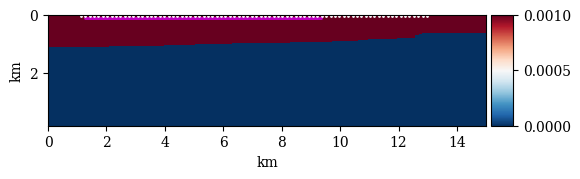

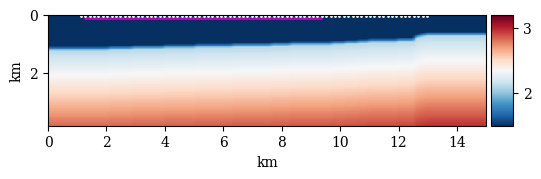

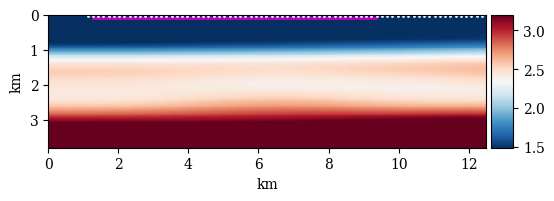

In [7]:
%run ./fwi_shared_check.ipynb

In [9]:
root_su_field = os.path.join(d._root_su, 'field/'); 
d.SEIS_FILE_P=root_su_field
data_p_backup = data_p.copy()
print(data_p_backup.shape, d.DT)
par_mutter = {'k': 7, 'b': -100, 'r': 30}
new_data_p = []
for idat in range(data_p.shape[0]):
    new_data_p.append(np.expand_dims(ld.mutter(data_p[idat, ...], **par_mutter), 0))
new_data_p = np.concatenate(new_data_p)
new_data_p.shape

(80, 324, 3000) None


(80, 324, 3000)

## Save field data to a new folder in /su/

In [10]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [11]:
from glob import glob
print(d._root_su)
print(root_su_field)
# copy_su_from_to(d._root_su,root_su_field)

./out_for_pasha/su
./out_for_pasha/su/field/


In [12]:
shots,filenames=d.get_shots_from_directory(d._root_su,keys=['_p'],return_filenames=True)
shots=shots[::20]
filenames=filenames[::20]
print(filenames)
for shot,filename in zip(shots,filenames):
    print(filename)
    plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path=filename.split('/')[-1]+'.png',show=0)

< ./out_for_pasha/su/seis_p.su.shot1 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot2 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot3 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot4 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot5 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot6 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot7 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot8 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot9 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot10 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot11 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot12 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot13 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot14 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot15 > np.array((324, 3000))
< ./out_for_pasha/su/seis_p.su.shot16 > np.array((324, 3000))
< ./out_for_pasha

# Write field data into created .su files

In [13]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames
fnames = get_fnames_pattern(root_su_field + '*.su.*')
print(fnames)
for i, f in enumerate(fnames):
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        tmp = new_data_p[i, :, ::d.NDT]
        dst.trace = tmp
        print(f, dst.tracecount, tmp.shape, end='\r')

80 files found in ./out_for_pasha/su/field/*.su.*
['./out_for_pasha/su/field/seis_p.su.shot1', './out_for_pasha/su/field/seis_p.su.shot2', './out_for_pasha/su/field/seis_p.su.shot3', './out_for_pasha/su/field/seis_p.su.shot4', './out_for_pasha/su/field/seis_p.su.shot5', './out_for_pasha/su/field/seis_p.su.shot6', './out_for_pasha/su/field/seis_p.su.shot7', './out_for_pasha/su/field/seis_p.su.shot8', './out_for_pasha/su/field/seis_p.su.shot9', './out_for_pasha/su/field/seis_p.su.shot10', './out_for_pasha/su/field/seis_p.su.shot11', './out_for_pasha/su/field/seis_p.su.shot12', './out_for_pasha/su/field/seis_p.su.shot13', './out_for_pasha/su/field/seis_p.su.shot14', './out_for_pasha/su/field/seis_p.su.shot15', './out_for_pasha/su/field/seis_p.su.shot16', './out_for_pasha/su/field/seis_p.su.shot17', './out_for_pasha/su/field/seis_p.su.shot18', './out_for_pasha/su/field/seis_p.su.shot19', './out_for_pasha/su/field/seis_p.su.shot20', './out_for_pasha/su/field/seis_p.su.shot21', './out_for_pa

In [1]:
def filter_seismic_data(path,dt=0.002,corner_frequency=5,fmax=10):
    # d=api.Denise('./',verbose=1)
    d=api.Denise('/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master',verbose=0)
    shots,filenames=d.get_shots_from_directory(path,return_filenames=True)
    print('low frequency data corner frequency, ',corner_frequency)
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    counter=0
    for shot,filename in zip(shots,filenames):
        ################    processing stage 1
        filtered_shot=bandpass(shot,fhi=6, dt=dt,order=8, btype='low')
        ################    processing stage 2
        filtered_shot2=bandpass(shot,flo=corner_frequency+0.8,dt=dt,order=8,btype='high')
        filtered_shot2_=bandpass(shot,flo=corner_frequency+0.8,fhi=6,dt=dt,order=8,btype='band') #for plotting purposes
        ################    processing stage 3
        filtered_shot3=zero_below_freq(filtered_shot2,corner_frequency+0.1,dt, disable=False,reverse=False)
        filtered_shot3_=zero_below_freq(filtered_shot2_,corner_frequency+0.1,dt, disable=False,reverse=False)
        ################
        plotting_flag=1
        if plotting_flag==1:
            shots_list=[0,22,44,66]
            if counter in shots_list:
                plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='shot_'+str(counter)+'.png',show=0)
                plot_shot(filtered_shot2,pclip=0.05,folder_path='./pictures_for_check',file_path='shot'+str(counter)+'_stage2.png',show=0)
                freqs,ps=plot_spectrum(shot,dt,fmax=fmax,folder_path='./pictures_for_check',file_path='spectrum_'+str(counter)+'_original.png')
                freqs,ps=plot_spectrum(filtered_shot2,dt,fmax=fmax,folder_path='./pictures_for_check',file_path='spectrum_'+str(counter)+'stage2.png')
        ################    chosen processing    
        with segyio.su.open(filename,"r+",endian='little',ignore_geometry=True) as dst:
            dst.trace=filtered_shot2
        # shot_read,read_filename=d.get_shots_from_datadir(keys=[filename],return_filenames=True); shot_read=shot_read[0]
        counter=counter+1
    return None

print(os.getcwd())
print(d.DT)
su_field_path1 = os.path.join(os.getcwd(),'su_field_high_pass_5_hz/')
su_field_path2 = os.path.join(os.getcwd(),'su_field/')

api._cmd('rm -r '+su_field_path1)
copy_su_from_to(root_su_field,su_field_path1)
filter_seismic_data(su_field_path1,dt=0.002,corner_frequency=5,fmax=10)

api._cmd('rm -r '+su_field_path2)
copy_su_from_to(root_su_field,su_field_path2)

/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha


NameError: name 'd' is not defined

In [21]:
# shots,filenames=d.get_shots_from_directory(su_field_path2,keys=['_p'],return_filenames=True)
# for shot in shots:
#     print(shot.shape)
shots,filenames=d.get_shots_from_directory(su_field_path1,keys=['_p'],return_filenames=True)
for shot in shots:
    print(shot.shape)

# shots=shots[::10]
# filenames=filenames[::10]
# print(filenames)
# for shot,filename in zip(shots,filenames):
#     print(filename)
#     plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='su_field_path2_'+filename.split('/')[-1]+'.png',show=0)

# shots,filenames=d.get_shots_from_directory(su_field_path1,keys=['_p'],return_filenames=True)
# shots=shots[::20]
# filenames=filenames[::20]
# print(filenames)
# for shot,filename in zip(shots,filenames):
#     print(filename)
#     # plot_shot(shot,pclip=0.05,folder_path='./pictures_for_check',file_path='su_field_path1_'+filename.split('/')[-1]+'.png',show=0)
#     freqs,ps=plot_spectrum(shot,0.002,fmax=10,folder_path='./pictures_for_check',file_path='su_field_path1_'+'spectrum_'+filename.split('/')[-1]+'stage2.png')

< /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/su_field_high_pass_5_hz/seis_p.su.shot1 > np.array((324, 3000))
< /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/su_field_high_pass_5_hz/seis_p.su.shot2 > np.array((324, 3000))
< /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/su_field_high_pass_5_hz/seis_p.su.shot3 > np.array((324, 3000))
< /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/su_field_high_pass_5_hz/seis_p.su.shot4 > np.array((324, 3000))
< /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/su_field_high_pass_5_hz/seis_p.su.shot5 > np.array((324, 3000))
< /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/su_field_high_pass_5_hz/seis_p.su.shot6 > np.array((324, 3000))
< /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for

In [ ]:
d.save_folder = os.path.join(root_fwi,'fwi_full_spectrum','fld')
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)

### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [ ]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

### Gradients

In [ ]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

In [ ]:
def get_model_last():
    all_fnames = []
    # vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    vps, fnames = d.get_fwi_models(['vp'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho'], return_filenames=True)
    all_fnames += fnames
    print(all_fnames)
    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)
    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    # print(vps)
    return model_last
    # return None
model_last=get_model_last()

# Compare wavefiedls before/after

In [ ]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)
print(d.save_folder)
if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

In [ ]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

In [ ]:
par_forward = {'run_command': 'mpirun -np 30', 'disable': False}
print(par_forward)

In [ ]:
d.NPROCX = 1
d.NPROCY = 1
d.verbose=1
d.forward(model_last, src, rec, **par_forward)

In [ ]:
def divmax(x): return x / np.max(np.abs(x))
d.verbose = 0    # don't show redundant print outs
if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

mpl.rcParams['figure.dpi']= 300
# for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
for ishot in [19, 62]:
    print(ishot)
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)